##3 classes: classical, jazz, rock

###Network: 
5 conv+max pooling, 2 dense 



In [1]:
#importing google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
#setting the working directory
%cd /gdrive/MyDrive/Colab Notebooks/NAML/Project

/gdrive/MyDrive/Colab Notebooks/NAML/Project


In [3]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import librosa
import os

tfk = tf.keras
tfkl = tf.keras.layers
seed = 42

In [4]:
dataset = []
# genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

genres = { 'classical': 0, 'jazz': 1, 'rock': 2}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'dataset_old/genres/{genre}'):
        songname = f'dataset_old/genres/{genre}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=2)
        ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512)
        ps = librosa.power_to_db(ps**2)
        dataset.append( (ps, genre_number) )
    print(str(genre+' done'))

classical done
jazz done
rock done


In [5]:
order = np.arange(start = 0, stop = 100, step = 1)

np.random.seed(42)

training = []
validation = []
test = []

for i in range(3):
  shuffle = np.random.permutation(order)
  for k in range(70):
    training.append(dataset[i*100 + shuffle[k]])
  for l in range(20):
    validation.append(dataset[i*100 + shuffle[l+70]])
  for m in range(10):
    test.append(dataset[i*100 + shuffle[m+90]])

In [6]:
X_train, Y_train = zip(*training)
X_valid, Y_valid = zip(*validation)
X_test, Y_test = zip(*test)

X_train = np.array([x.reshape( (128, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (128, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (128, 173, 1) ) for x in X_test])


Y_train = np.array(tfk.utils.to_categorical(Y_train, 3))
Y_valid = np.array(tfk.utils.to_categorical(Y_valid, 3))
Y_test = np.array(tfk.utils.to_categorical(Y_test, 3))

In [7]:
def build_model(input_shape, n_units):
# Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=128,
        kernel_size=(2, 2),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 3)
    )(conv5)


    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.2, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=64, name='Classifier', activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.2, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=n_units, activation='softmax', name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model

    return model

In [ ]:
n_units = 3
input_shape = (128,173,1)

model = build_model(input_shape, n_units)

model.summary()

In [ ]:
#first_callbacks = create_folders_and_callbacks(model_name='first')
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)

standard_history = model.fit(
    x = X_train,
    y = Y_train,
    epochs = 90,
    batch_size = 64,
    validation_data= (X_valid, Y_valid),
    callbacks = [early_stopping]
    )

Accuracy: 0.7667
Precision: 0.7976
Recall: 0.7667
F1: 0.7685


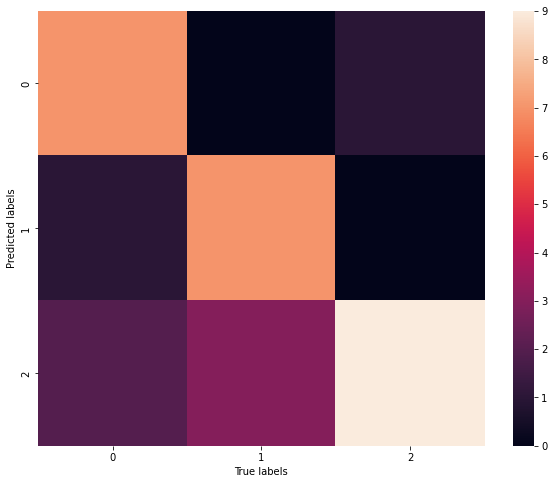

In [12]:
predictions = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T)#, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()